In [1]:
import glob
from PIL import Image
import cv2
from math import exp,pi,sin,cos
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import time
import pandas as pd
#import mkl_fft as fft
#内部コマンドは先頭に「!」を付ける、例：「!ls」

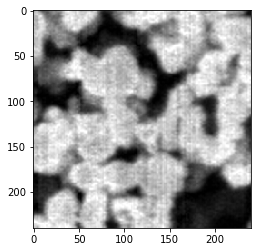

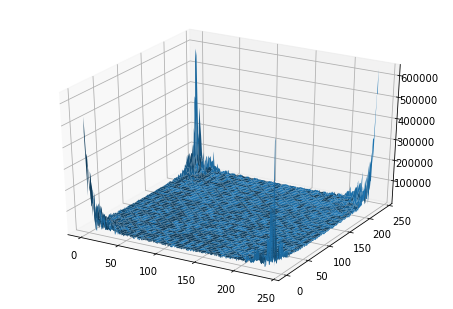

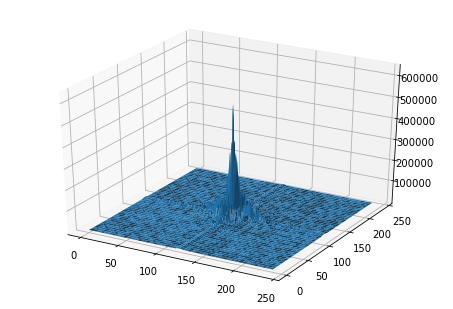

In [2]:
from mpl_toolkits.mplot3d import Axes3D
img = np.array(Image.open('/Users/shgtkmt/workspace/fourier_learning/train/0_0.tif'),'float64')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,255))
img = scaler.fit_transform(img)
plt.imshow(img, cmap='gray')
plt.show()
'''Imageオブジェクトに戻す
img2 = Image.fromarray(img)
print(img2.size)
'''
'''２次元表示例
x = np.linspace(0, 2*pi, 100)
y = np.sin(x)
plt.plot(x, y)
plt.show()
'''
cir_ave = 0
for i in range(239):
    cir_ave += img[0,i]
    cir_ave += img[i,-1]
    cir_ave += img[-1,-i]
    cir_ave += img[-i,0]
cir_ave /= 956
img -= cir_ave
for i in range(239):
    for j in range(12):
        img[j,i] = img[j,i]*sin((2*pi*j)/12)
        img[i,-j] = img[i,-j]*sin((2*pi*j)/12)
        img[-j,-i] = img[-j,-i]*sin((2*pi*j)/12)
        img[-i,j] = img[-i,j]*sin((2*pi*j)/12)
with open('./demo/demo.txt','w') as f:
    for y in range(240):
        for x in range(240):
            f.write(str(img[y,x]) + ' ')
        f.write('\n')
        
img = np.fft.fft2(img)
x = np.arange(0,240,1) #下と同じ
y = np.linspace(0, 240, 240) #上と同じ
_x, _y = np.meshgrid(x,y)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(_x,_y,np.absolute(img))
plt.show()

img = np.fft.fftshift(img)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(_x,_y,np.absolute(img))
plt.show()

# 3ch画像の調査
img = cv2.imread('./3ch/0_0.tiff')
def print_position(event, x, y, flags,param):
    if event == cv2.EVENT_LBUTTONDBLCLK:
        print(img[y,x,:])
cv2.namedWindow('img')
cv2.setMouseCallback('img', print_position)
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [102]:
# cuda無し
#フーリエあり

start = time.time()
train_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
test_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")

def a0edge_rm(local_f,x,y):
    arr = local_f
    cir_ave = 0
    num = 0
    if x < 8:
        empty_range_x = 8 - x
    else:
        empty_range_x = False
    if 248-1 < x+15:
        empty_range_x2 = (x+16) - 248
    else:
        empty_range_x2 = False
    flag_x = not(empty_range_x or empty_range_x2) #x方向での0パディング領域が存在しない == true
    if y < 8:
        empty_range_y = 8 - y
    else:
        empty_range_y = False
    if 248-1 < y+15:
        empty_range_y2 = (y+16) - 248
    else:
        empty_range_y2 = False
    flag_y = not(empty_range_y or empty_range_y2) #y方向での0パディング領域が存在しない == true
    if (flag_x and flag_y): #０パディング領域が存在しない場合
        for k in range(15):
            cir_ave += arr[0,k]
            cir_ave += arr[k,-1]
            cir_ave += arr[-1,-k]
            cir_ave += arr[-k,0]
        num = 60
        cir_ave /= num
        arr -= cir_ave
    elif (not(flag_x) and flag_y): #x方向のみに０パディング領域が存在する場合
        if (empty_range_x): #左側が０パディング
            for k in range(16 - empty_range_x):
                cir_ave += arr[0,k+empty_range_x]
                num += 1
                cir_ave += arr[-1,k+empty_range_x]
                num += 1
            for k in range(14):
                cir_ave += arr[1+k, empty_range_x]
                num += 1
                cir_ave += arr[1+k, -1]
                num += 1
            cir_ave /= num
            arr[:, empty_range_x:] -= cir_ave
        else: #右側が０パディング
            for k in range(16 - empty_range_x2):
                cir_ave += arr[0,k]
                num += 1
                cir_ave += arr[-1,k]
                num += 1
            for k in range(14):
                cir_ave += arr[1+k, 0]
                num += 1
                cir_ave += arr[1+k, -empty_range_x2]
                num += 1
            cir_ave /= num
            arr[:, :-empty_range_x2] -= cir_ave
    elif (flag_x and not(flag_y)): #y方向のみに０パディング領域が存在する場合
        if (empty_range_y): #上側が０パディング
            for k in range(16 - empty_range_y):
                cir_ave += arr[k+empty_range_y, 0]
                num += 1
                cir_ave += arr[k+empty_range_y, -1]
                num += 1
            for k in range(14):
                cir_ave += arr[empty_range_y, 1+k]
                num += 1
                cir_ave += arr[-1, 1+k]
                num += 1
            cir_ave /= num
            arr[empty_range_y:, :] -= cir_ave
        else: #下側が０パディング
            for k in range(16 - empty_range_y2):
                cir_ave += arr[k,0]
                num += 1
                cir_ave += arr[k,-1]
                num += 1
            for k in range(14):
                cir_ave += arr[0, 1+k]
                num += 1
                cir_ave += arr[-empty_range_y2, 1+k]
                num += 1
            cir_ave /= num
            arr[:-empty_range_y2, :] -= cir_ave
    else: #x、y方向ともに０パディング領域が存在する場合
        if(empty_range_x):#左側が０パディング領域
            if(empty_range_y):#左上側が０パディング領域
                for k in range(16 - empty_range_x):
                    cir_ave += arr[empty_range_y, k+empty_range_x]
                    num += 1
                    cir_ave += arr[-1, k+empty_range_x]
                    num += 1
                for k in range(14 - empty_range_y):
                    cir_ave += arr[k+empty_range_y+1, empty_range_x]
                    num += 1
                    cir_ave += arr[k+empty_range_y+1, -1]
                    num += 1
                cir_ave /= num
                arr[empty_range_y:, empty_range_x:] -= cir_ave
            else:#左下側が０パディング領域
                for k in range(16 - empty_range_x):
                    cir_ave += arr[0, k+empty_range_x]
                    num += 1
                    cir_ave += arr[-empty_range_y2, k+empty_range_x]
                    num += 1
                for k in range(14 - empty_range_y2):
                    cir_ave += arr[k, empty_range_x]
                    num += 1
                    cir_ave += arr[k, -1]
                    num += 1
                cir_ave /= num
                arr[:-empty_range_y2, empty_range_x:] -= cir_ave
        else:#右側が０パディング領域
            if(empty_range_y2):#右下が０パディング領域
                for k in range(16 - empty_range_x2):
                    cir_ave += arr[0, k]
                    num += 1
                    cir_ave += arr[-empty_range_y2, k]
                    num += 1
                for k in range(14 - empty_range_y2):
                    cir_ave += arr[k+1, 0]
                    num += 1
                    cir_ave += arr[k+1, -empty_range_x2]
                    num += 1
                cir_ave /= num
                arr[:-empty_range_y2, :-empty_range_x2] -= cir_ave
            else:#右上が０パディング領域
                for k in range(16 - empty_range_x2):
                    cir_ave += arr[empty_range_y, k]
                    num += 1
                    cir_ave += arr[-1, k]
                    num += 1
                for k in range(14 - empty_range_y):
                    cir_ave += arr[k+1+empty_range_y, 0]
                    num += 1
                    cir_ave += arr[k+1+empty_range_y, -empty_range_x2]
                    num += 1
                cir_ave /= num
                arr[empty_range_y:, :-empty_range_x2] -= cir_ave
    return arr

@jit
def myfourier(tiff_path):
    pre_img =  Image.open(tiff_path)
    pre_img = pre_img.convert('L')
    _x = pre_img.size[0]
    _y = pre_img.size[1]
    pre_img =  np.array(pre_img)
    X = np.zeros([1, _y, _x, 5],'float32')
    X[0,:,:,0] = pre_img
    img = np.zeros([_y+16, _x+16])
    img[8:-8, 8:-8] = pre_img
    local_f = np.zeros([17,17])
    cir_ave = 0
    for y in range(_y):
        for x in range(_x):
            local_f = img[y:y+17, x:x+17]
            #local_f = a0edge_rm(local_f,x,y)
            local_f = np.fft.fft2(local_f)
            #local_f = fft.fft2(local_f)
            local_f = np.fft.fftshift(local_f)
            for i in range(17):
                for j in range(17):
                    local_f[i,j] = np.absolute(local_f[i,j])
            X[0,y,x,4] = local_f.sum()#289
            X[0,y,x,3] = local_f[2:15, 2:15].sum()#169
            X[0,y,x,4] = (X[0,y,x,4] - X[0,y,x,3])
            X[0,y,x,2] = local_f[4:13, 4:13].sum()#81
            X[0,y,x,3] = (X[0,y,x,3] - X[0,y,x,2])
            X[0,y,x,1] = local_f[6:11, 6:11].sum()#25
            X[0,y,x,2] = (X[0,y,x,2] - X[0,y,x,1])
            X[0,y,x,1] = X[0,y,x,1] - local_f[8,8]
            X[0,y,x,1] = X[0,y,x,1]/24
            X[0,y,x,2] = X[0,y,x,2]/56
            X[0,y,x,3] = X[0,y,x,3]/88
            X[0,y,x,4] = X[0,y,x,4]/120
    return X

data_num = (len(train_path) - 1) - 26
X = myfourier(train_path[0])
for i in range(data_num):
    X = np.append(X,myfourier(train_path[i+1]),axis=0)
    
data_num = (len(test_path)-1 )-150
Xte = myfourier(test_path[150])
for i in range(data_num):
    Xte = np.append(Xte,myfourier(test_path[i+151]),axis=0)
    
caltime = time.time() - start
print(X.shape,Xte.shape,caltime/60)

C:\Users\shgtkmt\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\shgtkmt\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:190: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\shgtkmt\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\shgtkmt\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:195: ComplexWarning: Casting complex values to real discards the imaginary part


(150, 240, 240, 5) (26, 240, 240, 5) 85.82504359086354


In [2]:
#フーリエ無し

def origin_data(path):
    img = Image.open(path)
    _x = int(img.size[0])
    _y = int(img.size[1])
    noX = np.zeros([1,_y,_x,1])
    noX[0,:,:,0] = np.array(img)
    return noX

train_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
data_num = (len(train_path) - 1) - 26
noX = origin_data(train_path[0])
for i in range(data_num):
    noX = np.append(noX,origin_data(train_path[i+1]),axis=0)
    
test_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
data_num = (len(test_path)-1 ) -150
noXte = origin_data(test_path[150])
for i in range(data_num):
    noXte = np.append(noXte,origin_data(test_path[i+151]),axis=0)
    
print(noX.shape,noXte.shape)

(150, 240, 240, 1) (26, 240, 240, 1)


In [3]:
start = time.time()
'''
with open("./../data/cnn_Fourier/X.txt", "w") as f:
    for num in range(X.shape[0]):
        f.write('flag0\n')
        for row in range(X.shape[1]):
            f.write('flag1\n')
            for column in range(X.shape[2]):
                f.write('flag2\n')
                for ch in range(X.shape[3]):
                    f.write(str(X[num,row,column,ch]))
                    f.write('\n')
                    
with open("./../data/cnn_Fourier/Xte.txt", "w") as f:
    for num in range(Xte.shape[0]):
        f.write('flag0\n')
        for row in range(Xte.shape[1]):
            f.write('flag1\n')
            for column in range(Xte.shape[2]):
                f.write('flag2\n')
                for ch in range(Xte.shape[3]):
                    f.write(str(Xte[num,row,column,ch]))
                    f.write('\n')

#'''
#'''
X = np.zeros([150,240,240,5],'float32')
with open("./../data/cnn_Fourier/X.txt", "r") as f:
    num=-1
    row=-1
    column=-1
    ch=0
    for line in f:
        if (line.find('flag0') == 0):
            num += 1
            row = -1
        elif (line.find('flag1') == 0):
            row += 1
            column = -1
        elif (line.find('flag2') == 0):
            column += 1
            ch = 0
        else:
            X[num,row,column,ch] = float(line)
            ch += 1
        
Xte = np.zeros([26,240,240,5],'float32')
with open("./../data/cnn_Fourier/Xte.txt", "r") as f:
    num=-1
    row=-1
    column=-1
    ch=0
    for line in f:
        if (line.find('flag0') == 0):
            num += 1
            row = -1
        elif (line.find('flag1') == 0):
            row += 1
            column = -1
        elif (line.find('flag2') == 0):
            column += 1
            ch = 0
        else:
            Xte[num,row,column,ch] = float(line)
            ch += 1
#'''
caltime = time.time() - start
print(X.shape,Xte.shape,caltime/60)

(150, 240, 240, 5) (26, 240, 240, 5) 1.2182303110758463


In [45]:
# fftをcudaで（途中）

from numba import cuda
from accelerate.cuda import fft
grid = (8,8)
block = (32,32) 
#240,240が良いが、最大スレッド数がgtx1060は１グリッドあたり1024個で、warp的に32の倍数にしている
#x, y = cuda.grid(2)

train_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
test_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
img =  Image.open(train_path[0])
img = img.convert('L')
img =  np.asarray(img)


#fft.fft(img, _out)


In [46]:
#低周波領域は基本的に強度が大きいから操作
'''
X_proc = X
↑は参照型でのポインタ渡しだからダメ！
'''
X_proc = np.array(X)
Xte_proc = np.array(Xte)
for n in range(150):
    for y in range(240):
        for x in range(240):
            X_proc[n,y,x,1] /= 10
for n in range(26):
    for y in range(240):
        for x in range(240):
            Xte_proc[n,y,x,1] /= 10
            
print(X_proc[0,0,10,1],X[0,0,10,1])

179.688 1796.88


In [4]:
# 2値化教師データ

def mask_check(mask_path):
    mask = Image.open(mask_path)
    _x = int(mask.size[0])
    _y = int(mask.size[1])
    Y = np.zeros([1, _y, _x])
    mask = np.array(mask)
    for y in range(_y):
        for x in range(_x):
            if(mask[y,x]):
                Y[0,y,x] = 1
    return Y

train_ans_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train_ans//*.tif")
test_ans_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train_ans//*.tif")

data_num = (len(train_ans_path) - 1) - 26
Y = mask_check(train_ans_path[0])
for i in range(data_num):
    Y = np.append(Y,mask_check(train_ans_path[i+1]),axis=0)

data_num = (len(test_ans_path)-1) -150
Yte = mask_check(test_ans_path[150])
for i in range(data_num):
    Yte = np.append(Yte,mask_check(test_ans_path[i+151]),axis=0)

print(Y.shape,Yte.shape)

(150, 240, 240) (26, 240, 240)


In [5]:
# 3値化教師データ

ans3ch_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/3ch/*.tiff")
ch_num = len(ans3ch_path)
ch = np.zeros((ch_num, 240, 240))
flag = 0
check = [243,168,0]
img = cv2.imread(ans3ch_path[0])
ch_num -= 1
for y in range(240):
    for x in range(240):
        for i in range(3):
            if img[y,x,i] == check[i]:
                flag += 1
        if flag == 3:
            ch[0,y,x] = 1
        flag = 0
for n in range(ch_num):
    img = cv2.imread(ans3ch_path[n+1])
    for y in range(240):
        for x in range(240):
            for i in range(3):
                if img[y,x,i] == check[i]:
                    flag += 1
            if flag == 3:
                ch[n+1,y,x] = 1
            flag = 0
            
print(ch.shape)
chY = np.zeros([150,240,240,1])
chY[:,:,:,0] = Y[:,:,:]
chY = np.append(chY, ch[:150:,:,:].reshape([150,240,240,1]), axis=3)
chYte = np.zeros([26,240,240,1])
chYte[:,:,:,0] = Yte[:,:,:]
chYte = np.append(chYte, ch[-26:,:,:].reshape([26,240,240,1]), axis=3)
del ch
print(chY.shape,chYte.shape)

(176, 240, 240)
(150, 240, 240, 2) (26, 240, 240, 2)


In [28]:
# FCN
from keras.layers import Input, Activation #,Dropout
from keras.layers.core import Reshape
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ThresholdedReLU, LeakyReLU
from keras.layers.merge import Concatenate, Add

#フーリエ無(240,240,1) フーリエ有(240,240,5)
input_img = Input(shape=(240,240,5))
x = Conv2D(10, (17, 17), padding='same')(input_img)
# 目的：よりローカルな情報にする
x = Conv2D(10, (9, 9), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x1 = MaxPooling2D(pool_size=(5, 5))(x) #shape=(48,48,10)
# 目的：ローカルとフローバルの繋ぎ
x = Conv2D(15, (5, 5), padding='same')(x1)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x2 = MaxPooling2D(pool_size=(2, 2))(x) #shape=(24,24,15)
# 目的：グローバルな情報
x = Conv2D(20, (3, 3), padding='same')(x2)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x) #shape=(12,12,20)
# 目的：よりグローバルな情報というよりチャンネル合わせ
x = Conv2D(25, (2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#upsampling
x = UpSampling2D((2, 2))(x) #shape=(24,24,25)
x = Concatenate()([x2, x])
x = Conv2D(20, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x) #shape=(80,80,20)
x = Concatenate()([x1, x])
x = Conv2D(5, (5, 5), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling2D((5, 5))(x)

#fin 1_classか2_classの選択
x = Conv2D(1,(9, 9), padding='same')(x)
x = Reshape((240,240))(x)
#x = Conv2D(2,(9, 9), padding='same')(x)
#x = Reshape((240,240,2))(x)

x = Activation('sigmoid')(x)
x = ThresholdedReLU(theta=0.5)(x)

from keras.models import Model
model = Model(input_img, x)
model.compile(loss="binary_crossentropy", 
              optimizer='adam',
             metrics=['accuracy'])

In [29]:
model.fit(X, Y, epochs=10, batch_size=10, validation_split=0)

#フーリエ有
#model.load_weights('./img/weights2.h5', by_name=False) # 2値化
#model.load_weights('./img/weights3.h5', by_name=False) # 3値化
#フーリエ無
#model.load_weights('./img/weights2_nothing.h5', by_name=False) #2値化
#model.load_weights('./img/weights2_nothing10.h5' by_name=False) #最上層フィルタ５０枚
#model.load_weights('./img/weights3_nothing.h5', by_name=False) #3値化

Epoch 1/10
150/150 [==============================] - 4s - loss: 3.4910 - acc: 0.7067     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.3710 - acc: 0.8347     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.1588 - acc: 0.8541     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.0706 - acc: 0.8650     
Epoch 5/10
150/150 [==============================] - 1s - loss: 1.0875 - acc: 0.8688     
Epoch 6/10
150/150 [==============================] - 1s - loss: 1.1008 - acc: 0.8702     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0633 - acc: 0.8718     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0257 - acc: 0.8745     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0740 - acc: 0.8760     
Epoch 10/10
150/150 [==============================] - 1s - loss: 1.0624 - acc: 0.8775     


In [32]:
loss_and_metrics = model.evaluate(Xte,Yte)
print("\n{} loss:{} accuracy:{}".format(len(loss_and_metrics),loss_and_metrics[0],loss_and_metrics[1]))
print(model.summary())
#from keras.utils import plot_model
#plot_model(model, to_file='./img/model.png', show_shapes=True)

#フーリエ有
#model.save_weights('./img/weights2.h5') #2値化
#model.save_weights('./img/weights3.h5') #3値化
#フーリエ無
#model.save_weights('./img/weights2_nothing.h5') #2値化
#model.save_weights('./img/weights2_nothing10.h5') #最上層フィルタ５０枚
#model.save_weights('./img/weights3_nothing.h5') #3値化

26/26 [==============================] - 0s

2 loss:1.0064527988433838 accuracy:0.8611578941345215
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_26 (InputLayer)            (None, 240, 240, 5)   0                                            
____________________________________________________________________________________________________
conv2d_201 (Conv2D)              (None, 240, 240, 10)  14460       input_26[0][0]                   
____________________________________________________________________________________________________
conv2d_202 (Conv2D)              (None, 240, 240, 10)  8110        conv2d_201[0][0]                 
____________________________________________________________________________________________________
batch_normalization_151 (BatchNo (None, 240, 240, 10)  40          conv2d_202[0][0]          

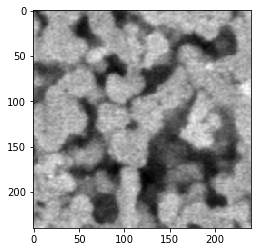

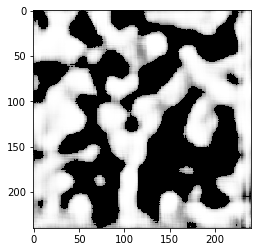

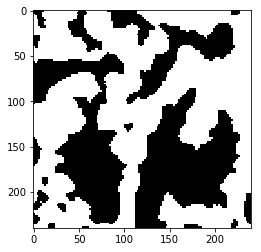

In [31]:
# 2値化出力

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,255))
plt.imshow(Xte[12,:,:,0], cmap='gray')
plt.show()
ans = model.predict_on_batch(Xte)
img = scaler.fit_transform(ans[12,:,:])
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(Yte[12,:,:], cmap='gray')
plt.show()

for i in range(26):
    img = Image.fromarray(ans[i,:,:])
    img.save('./../results/result_' + str(i) + '.tiff')

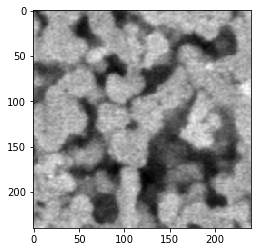

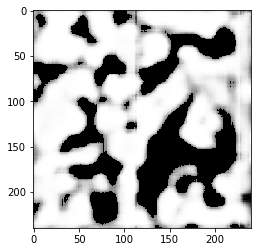

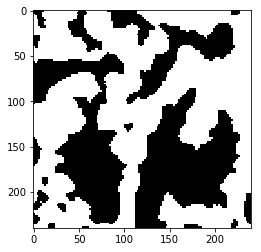

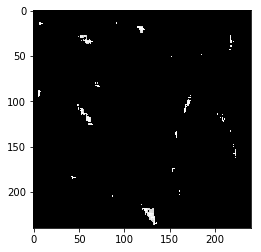

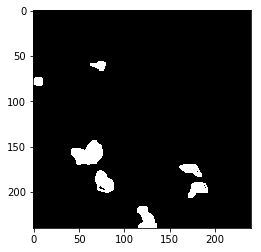

In [180]:
# ３値化出力

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,255))
plt.imshow(Xte[12,:,:,0], cmap='gray')
plt.show()
ans = model.predict_on_batch(noXte)
img1 = scaler.fit_transform(ans[12,:,:,0])
img2 = scaler.fit_transform(ans[12,:,:,1])
plt.imshow(img1, cmap='gray')
plt.show()
plt.imshow(chYte[12,:,:,0], cmap='gray')
plt.show()
plt.imshow(img2, cmap='gray')
plt.show()
plt.imshow(chYte[12,:,:,1], cmap='gray')
plt.show()

for i in range(26):
    img1 = Image.fromarray(ans[i,:,:,0])
    img1.save('./../results/result1_' + str(i) + '.tiff')
    img2 = Image.fromarray(ans[i,:,:,1])
    img2.save('./../results/result2_' + str(i) + '.tiff')

In [174]:
#no-Fourier

results = np.zeros([20,6],dtype='float32')

for l in range(20):
    from keras.layers import Input, Activation #,Dropout
    from keras.layers.core import Reshape
    from keras.layers.convolutional import Conv2D, UpSampling2D
    from keras.layers.pooling import MaxPooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers.advanced_activations import ThresholdedReLU, LeakyReLU
    from keras.layers.merge import Concatenate, Add

    #フーリエ無(240,240,1) フーリエ有(240,240,5)
    input_img = Input(shape=(240,240,1))
    x = Conv2D(10, (17, 17), padding='same')(input_img)
    # 目的：よりローカルな情報にする
    x = Conv2D(10, (9, 9), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x1 = MaxPooling2D(pool_size=(5, 5))(x) #shape=(48,48,10)
    # 目的：ローカルとフローバルの繋ぎ
    x = Conv2D(15, (5, 5), padding='same')(x1)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x) #shape=(24,24,15)
    # 目的：グローバルな情報
    x = Conv2D(20, (3, 3), padding='same')(x2)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) #shape=(12,12,20)
    # 目的：よりグローバルな情報というよりチャンネル合わせ
    x = Conv2D(25, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    #upsampling
    x = UpSampling2D((2, 2))(x) #shape=(24,24,25)
    x = Concatenate()([x2, x])
    x = Conv2D(20, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x) #shape=(80,80,20)
    x = Concatenate()([x1, x])
    x = Conv2D(5, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((5, 5))(x)

    #fin 1_classか2_classの選択
    x = Conv2D(1,(9, 9), padding='same')(x)
    x = Reshape((240,240))(x)
    #x = Conv2D(2,(9, 9), padding='same')(x)
    #x = Reshape((240,240,2))(x)

    x = Activation('sigmoid')(x)
    x = ThresholdedReLU(theta=0.5)(x)

    from keras.models import Model
    model = Model(input_img, x)
    model.compile(loss="binary_crossentropy", 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(noX, Y, epochs=10, batch_size=10, validation_split=0)
    ans = model.predict_on_batch(noXte)

    tp_all = 0
    tn_all = 0
    fp_all = 0
    fn_all = 0
    _sum_all = 0
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(ans[n,y,x]>=0.5 and Yte[n,y,x]==1):
                    #true positive
                    tp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==0):
                    #true negative
                    tn_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]>=0.5 and Yte[n,y,x]==0):
                    #false positive
                    fp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==1):
                    #false negative
                    fn_all += 1
                    _sum_all += 1
                else:
                    print('error')
    results[l,0] = tp_all
    results[l,1] = tn_all
    results[l,2] = fp_all
    results[l,3] = fn_all

    _p = 0
    _n = 0
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(chYte[n,y,x,1] == 1):
                    if(ans[n,y,x]>=0.5):
                        #positive
                        _p += 1
                    elif(ans[n,y,x]<0.5):
                        #negative
                        _n += 1
                    else:
                        print('error')
    results[l,4] = _n
    results[l,5] = _p
    
df = pd.DataFrame(results, columns=['TP','TN','FP','FN','blur_tn','blur_fp'])
df.to_csv("./img/no-Fourier.csv")

Epoch 1/10
150/150 [==============================] - 5s - loss: 1.2185 - acc: 0.7864     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.1007 - acc: 0.8416     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.0642 - acc: 0.8544     
Epoch 4/10
150/150 [==============================] - 1s - loss: 0.9888 - acc: 0.8600     
Epoch 5/10
150/150 [==============================] - 1s - loss: 1.0266 - acc: 0.8659     
Epoch 6/10
150/150 [==============================] - 1s - loss: 0.9832 - acc: 0.8692     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0361 - acc: 0.8699     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0042 - acc: 0.8734     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0235 - acc: 0.8757     
Epoch 10/10
150/150 [==============================] - 1s - loss: 1.0343 - acc: 0.8745     
Epoch 1/10
150/150 [==============================] - 5s - loss: 2.3489 - acc: 0.7772    

150/150 [==============================] - 1s - loss: 1.0336 - acc: 0.8791     
Epoch 1/10
150/150 [==============================] - 6s - loss: 3.6567 - acc: 0.7063     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.9955 - acc: 0.8122     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.5274 - acc: 0.8415     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.3791 - acc: 0.8541     
Epoch 5/10
150/150 [==============================] - 1s - loss: 1.2961 - acc: 0.8631     
Epoch 6/10
150/150 [==============================] - 1s - loss: 1.2533 - acc: 0.8667     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.2380 - acc: 0.8683     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.2278 - acc: 0.8723     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.2010 - acc: 0.8741     
Epoch 10/10
150/150 [==============================] - 1s - loss: 1.1789 - acc: 0.8745     
Epoch 1/1

In [176]:
#no-Fourier(フィルタ５０枚)

results = np.zeros([20,6],dtype='float32')

for l in range(20):
    from keras.layers import Input, Activation #,Dropout
    from keras.layers.core import Reshape
    from keras.layers.convolutional import Conv2D, UpSampling2D
    from keras.layers.pooling import MaxPooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers.advanced_activations import ThresholdedReLU, LeakyReLU
    from keras.layers.merge import Concatenate, Add

    #フーリエ無(240,240,1) フーリエ有(240,240,5)
    input_img = Input(shape=(240,240,1))
    x = Conv2D(50, (17, 17), padding='same')(input_img)
    # 目的：よりローカルな情報にする
    x = Conv2D(10, (9, 9), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x1 = MaxPooling2D(pool_size=(5, 5))(x) #shape=(48,48,10)
    # 目的：ローカルとフローバルの繋ぎ
    x = Conv2D(15, (5, 5), padding='same')(x1)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x) #shape=(24,24,15)
    # 目的：グローバルな情報
    x = Conv2D(20, (3, 3), padding='same')(x2)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) #shape=(12,12,20)
    # 目的：よりグローバルな情報というよりチャンネル合わせ
    x = Conv2D(25, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    #upsampling
    x = UpSampling2D((2, 2))(x) #shape=(24,24,25)
    x = Concatenate()([x2, x])
    x = Conv2D(20, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x) #shape=(80,80,20)
    x = Concatenate()([x1, x])
    x = Conv2D(5, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((5, 5))(x)

    #fin 1_classか2_classの選択
    x = Conv2D(1,(9, 9), padding='same')(x)
    x = Reshape((240,240))(x)
    #x = Conv2D(2,(9, 9), padding='same')(x)
    #x = Reshape((240,240,2))(x)

    x = Activation('sigmoid')(x)
    x = ThresholdedReLU(theta=0.5)(x)

    from keras.models import Model
    model = Model(input_img, x)
    model.compile(loss="binary_crossentropy", 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(noX, Y, epochs=10, batch_size=10, validation_split=0)
    ans = model.predict_on_batch(noXte)

    tp_all = 0
    tn_all = 0
    fp_all = 0
    fn_all = 0
    _sum_all = 0
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(ans[n,y,x]>=0.5 and Yte[n,y,x]==1):
                    #true positive
                    tp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==0):
                    #true negative
                    tn_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]>=0.5 and Yte[n,y,x]==0):
                    #false positive
                    fp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==1):
                    #false negative
                    fn_all += 1
                    _sum_all += 1
                else:
                    print('error')
    results[l,0] = tp_all
    results[l,1] = tn_all
    results[l,2] = fp_all
    results[l,3] = fn_all

    _p = 0
    _n = 0
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(chYte[n,y,x,1] == 1):
                    if(ans[n,y,x]>=0.5):
                        #positive
                        _p += 1
                    elif(ans[n,y,x]<0.5):
                        #negative
                        _n += 1
                    else:
                        print('error')
    results[l,4] = _n
    results[l,5] = _p
    
df = pd.DataFrame(results, columns=['TP','TN','FP','FN','blur_tn','blur_fp'])
df.to_csv("./img/no-Fourier50.csv")

Epoch 1/10
150/150 [==============================] - 7s - loss: 2.8360 - acc: 0.7415     
Epoch 2/10
150/150 [==============================] - 2s - loss: 1.2546 - acc: 0.8377     
Epoch 3/10
150/150 [==============================] - 2s - loss: 1.2001 - acc: 0.8548     
Epoch 4/10
150/150 [==============================] - 2s - loss: 1.0656 - acc: 0.8652     
Epoch 5/10
150/150 [==============================] - 2s - loss: 1.1345 - acc: 0.8702     
Epoch 6/10
150/150 [==============================] - 2s - loss: 1.0950 - acc: 0.8726     
Epoch 7/10
150/150 [==============================] - 2s - loss: 1.0740 - acc: 0.8737     
Epoch 8/10
150/150 [==============================] - 2s - loss: 1.1397 - acc: 0.8758     
Epoch 9/10
150/150 [==============================] - 2s - loss: 1.0394 - acc: 0.8776     
Epoch 10/10
150/150 [==============================] - 2s - loss: 1.0698 - acc: 0.8796     
Epoch 1/10
150/150 [==============================] - 8s - loss: 1.7172 - acc: 0.7902    

150/150 [==============================] - 2s - loss: 1.0947 - acc: 0.8738     
Epoch 1/10
150/150 [==============================] - 9s - loss: 1.6287 - acc: 0.7868     
Epoch 2/10
150/150 [==============================] - 2s - loss: 1.0782 - acc: 0.8372     
Epoch 3/10
150/150 [==============================] - 2s - loss: 1.0924 - acc: 0.8544     
Epoch 4/10
150/150 [==============================] - 2s - loss: 1.0342 - acc: 0.8632     
Epoch 5/10
150/150 [==============================] - 2s - loss: 1.0354 - acc: 0.8643     
Epoch 6/10
150/150 [==============================] - 2s - loss: 1.0598 - acc: 0.8693     
Epoch 7/10
150/150 [==============================] - 2s - loss: 1.0293 - acc: 0.8723     
Epoch 8/10
150/150 [==============================] - 2s - loss: 1.0391 - acc: 0.8727     
Epoch 9/10
150/150 [==============================] - 2s - loss: 1.0374 - acc: 0.8744     
Epoch 10/10
150/150 [==============================] - 2s - loss: 1.0536 - acc: 0.8765     
Epoch 1/1

In [171]:
#on-fourier

results = np.zeros([20,6],dtype='float32')

for l in range(20):
    from keras.layers import Input, Activation #,Dropout
    from keras.layers.core import Reshape
    from keras.layers.convolutional import Conv2D, UpSampling2D
    from keras.layers.pooling import MaxPooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers.advanced_activations import ThresholdedReLU, LeakyReLU
    from keras.layers.merge import Concatenate, Add

    #フーリエ無(240,240,1) フーリエ有(240,240,5)
    input_img = Input(shape=(240,240,5))
    x = Conv2D(10, (17, 17), padding='same')(input_img)
    # 目的：よりローカルな情報にする
    x = Conv2D(10, (9, 9), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x1 = MaxPooling2D(pool_size=(5, 5))(x) #shape=(48,48,10)
    # 目的：ローカルとフローバルの繋ぎ
    x = Conv2D(15, (5, 5), padding='same')(x1)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x) #shape=(24,24,15)
    # 目的：グローバルな情報
    x = Conv2D(20, (3, 3), padding='same')(x2)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) #shape=(12,12,20)
    # 目的：よりグローバルな情報というよりチャンネル合わせ
    x = Conv2D(25, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    #upsampling
    x = UpSampling2D((2, 2))(x) #shape=(24,24,25)
    x = Concatenate()([x2, x])
    x = Conv2D(20, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x) #shape=(80,80,20)
    x = Concatenate()([x1, x])
    x = Conv2D(5, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((5, 5))(x)

    #fin 1_classか2_classの選択
    x = Conv2D(1,(9, 9), padding='same')(x)
    x = Reshape((240,240))(x)
    #x = Conv2D(2,(9, 9), padding='same')(x)
    #x = Reshape((240,240,2))(x)

    x = Activation('sigmoid')(x)
    x = ThresholdedReLU(theta=0.5)(x)

    from keras.models import Model
    model = Model(input_img, x)
    model.compile(loss="binary_crossentropy", 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(X, Y, epochs=10, batch_size=10, validation_split=0)
    ans = model.predict_on_batch(Xte)

    tp_all = 0
    tn_all = 0
    fp_all = 0
    fn_all = 0
    _sum_all = 0
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(ans[n,y,x]>=0.5 and Yte[n,y,x]==1):
                    #true positive
                    tp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==0):
                    #true negative
                    tn_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]>=0.5 and Yte[n,y,x]==0):
                    #false positive
                    fp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==1):
                    #false negative
                    fn_all += 1
                    _sum_all += 1
                else:
                    print('error')
    results[l,0] = tp_all
    results[l,1] = tn_all
    results[l,2] = fp_all
    results[l,3] = fn_all

    _p = 0
    _n = 0
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(chYte[n,y,x,1] == 1):
                    if(ans[n,y,x]>=0.5):
                        #positive
                        _p += 1
                    elif(ans[n,y,x]<0.5):
                        #negative
                        _n += 1
                    else:
                        print('error')
    results[l,4] = _n
    results[l,5] = _p
    
df = pd.DataFrame(results, columns=['TP','TN','FP','FN','blur_tn','blur_fp'])
df.to_csv("./img/no_fourier.csv")

Epoch 1/10
150/150 [==============================] - 4s - loss: 3.7495 - acc: 0.6738     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.0950 - acc: 0.8298     
Epoch 3/10
150/150 [==============================] - 1s - loss: 0.9980 - acc: 0.8537     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.0304 - acc: 0.8629     
Epoch 5/10
150/150 [==============================] - 1s - loss: 0.9444 - acc: 0.8660     
Epoch 6/10
150/150 [==============================] - 1s - loss: 1.0548 - acc: 0.8692     
Epoch 7/10
150/150 [==============================] - 1s - loss: 0.9616 - acc: 0.8710     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0209 - acc: 0.8740     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0270 - acc: 0.8759     
Epoch 10/10
150/150 [==============================] - 1s - loss: 0.9531 - acc: 0.8763     
Epoch 1/10
150/150 [==============================] - 4s - loss: 1.7223 - acc: 0.7376    

150/150 [==============================] - 1s - loss: 1.0616 - acc: 0.8765     
Epoch 1/10
150/150 [==============================] - 5s - loss: 3.2771 - acc: 0.7142     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.3113 - acc: 0.8344     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.1702 - acc: 0.8519     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.0858 - acc: 0.8602     
Epoch 5/10
150/150 [==============================] - 1s - loss: 0.9688 - acc: 0.8671     
Epoch 6/10
150/150 [==============================] - 1s - loss: 0.9868 - acc: 0.8715     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0060 - acc: 0.8718     
Epoch 8/10
150/150 [==============================] - 1s - loss: 0.9956 - acc: 0.8737     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0610 - acc: 0.8733     
Epoch 10/10
150/150 [==============================] - 1s - loss: 0.9886 - acc: 0.8771     
Epoch 1/1

In [177]:
#on-fourier(強度処理)

results = np.zeros([20,6],dtype='float32')

for l in range(20):
    from keras.layers import Input, Activation #,Dropout
    from keras.layers.core import Reshape
    from keras.layers.convolutional import Conv2D, UpSampling2D
    from keras.layers.pooling import MaxPooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers.advanced_activations import ThresholdedReLU, LeakyReLU
    from keras.layers.merge import Concatenate, Add

    #フーリエ無(240,240,1) フーリエ有(240,240,5)
    input_img = Input(shape=(240,240,5))
    x = Conv2D(10, (17, 17), padding='same')(input_img)
    # 目的：よりローカルな情報にする
    x = Conv2D(10, (9, 9), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x1 = MaxPooling2D(pool_size=(5, 5))(x) #shape=(48,48,10)
    # 目的：ローカルとフローバルの繋ぎ
    x = Conv2D(15, (5, 5), padding='same')(x1)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x) #shape=(24,24,15)
    # 目的：グローバルな情報
    x = Conv2D(20, (3, 3), padding='same')(x2)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) #shape=(12,12,20)
    # 目的：よりグローバルな情報というよりチャンネル合わせ
    x = Conv2D(25, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    #upsampling
    x = UpSampling2D((2, 2))(x) #shape=(24,24,25)
    x = Concatenate()([x2, x])
    x = Conv2D(20, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x) #shape=(80,80,20)
    x = Concatenate()([x1, x])
    x = Conv2D(5, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((5, 5))(x)

    #fin 1_classか2_classの選択
    x = Conv2D(1,(9, 9), padding='same')(x)
    x = Reshape((240,240))(x)
    #x = Conv2D(2,(9, 9), padding='same')(x)
    #x = Reshape((240,240,2))(x)

    x = Activation('sigmoid')(x)
    x = ThresholdedReLU(theta=0.5)(x)

    from keras.models import Model
    model = Model(input_img, x)
    model.compile(loss="binary_crossentropy", 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(X, Y, epochs=10, batch_size=10, validation_split=0)
    ans = model.predict_on_batch(Xte)

    tp_all = 0
    tn_all = 0
    fp_all = 0
    fn_all = 0
    _sum_all = 0
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(ans[n,y,x]>=0.5 and Yte[n,y,x]==1):
                    #true positive
                    tp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==0):
                    #true negative
                    tn_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]>=0.5 and Yte[n,y,x]==0):
                    #false positive
                    fp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==1):
                    #false negative
                    fn_all += 1
                    _sum_all += 1
                else:
                    print('error')
    results[l,0] = tp_all
    results[l,1] = tn_all
    results[l,2] = fp_all
    results[l,3] = fn_all

    _p = 0
    _n = 0
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(chYte[n,y,x,1] == 1):
                    if(ans[n,y,x]>=0.5):
                        #positive
                        _p += 1
                    elif(ans[n,y,x]<0.5):
                        #negative
                        _n += 1
                    else:
                        print('error')
    results[l,4] = _n
    results[l,5] = _p
    
df = pd.DataFrame(results, columns=['TP','TN','FP','FN','blur_tn','blur_fp'])
df.to_csv("./img/on_fourier+.csv")

Epoch 1/10
150/150 [==============================] - 9s - loss: 3.1317 - acc: 0.7247     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.2533 - acc: 0.8368     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.1355 - acc: 0.8533     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.1018 - acc: 0.8617     
Epoch 5/10
150/150 [==============================] - 1s - loss: 1.1112 - acc: 0.8656     
Epoch 6/10
150/150 [==============================] - 1s - loss: 1.0015 - acc: 0.8684     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0269 - acc: 0.8702     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0418 - acc: 0.8735     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0447 - acc: 0.8742     
Epoch 10/10
150/150 [==============================] - 1s - loss: 0.9740 - acc: 0.8765     
Epoch 1/10
150/150 [==============================] - 9s - loss: 2.7278 - acc: 0.7438    

150/150 [==============================] - 1s - loss: 1.0110 - acc: 0.8739     
Epoch 1/10
150/150 [==============================] - 10s - loss: 2.0756 - acc: 0.7542    
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.2104 - acc: 0.8400     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.0556 - acc: 0.8533     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.2038 - acc: 0.8579     
Epoch 5/10
150/150 [==============================] - 1s - loss: 1.0637 - acc: 0.8625     
Epoch 6/10
150/150 [==============================] - 1s - loss: 1.0865 - acc: 0.8655     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0769 - acc: 0.8695     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0917 - acc: 0.8701     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0387 - acc: 0.8727     
Epoch 10/10
150/150 [==============================] - 1s - loss: 1.0626 - acc: 0.8743     
Epoch 1/1

In [6]:
#3ch no-fourier

results = np.zeros([20,12],dtype='float32')

for l in range(20):
    from keras.layers import Input, Activation #,Dropout
    from keras.layers.core import Reshape
    from keras.layers.convolutional import Conv2D, UpSampling2D
    from keras.layers.pooling import MaxPooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers.advanced_activations import ThresholdedReLU, LeakyReLU
    from keras.layers.merge import Concatenate, Add

    #フーリエ無(240,240,1) フーリエ有(240,240,5)
    input_img = Input(shape=(240,240,1))
    x = Conv2D(10, (17, 17), padding='same')(input_img)
    # 目的：よりローカルな情報にする
    x = Conv2D(10, (9, 9), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x1 = MaxPooling2D(pool_size=(5, 5))(x) #shape=(48,48,10)
    # 目的：ローカルとフローバルの繋ぎ
    x = Conv2D(15, (5, 5), padding='same')(x1)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x) #shape=(24,24,15)
    # 目的：グローバルな情報
    x = Conv2D(20, (3, 3), padding='same')(x2)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) #shape=(12,12,20)
    # 目的：よりグローバルな情報というよりチャンネル合わせ
    x = Conv2D(25, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    #upsampling
    x = UpSampling2D((2, 2))(x) #shape=(24,24,25)
    x = Concatenate()([x2, x])
    x = Conv2D(20, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x) #shape=(80,80,20)
    x = Concatenate()([x1, x])
    x = Conv2D(5, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((5, 5))(x)

    #fin 1_classか2_classの選択
    #x = Conv2D(1,(9, 9), padding='same')(x)
    #x = Reshape((240,240))(x)
    x = Conv2D(2,(9, 9), padding='same')(x)
    x = Reshape((240,240,2))(x)

    x = Activation('sigmoid')(x)
    x = ThresholdedReLU(theta=0.5)(x)

    from keras.models import Model
    model = Model(input_img, x)
    model.compile(loss="binary_crossentropy", 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(noX, chY, epochs=10, batch_size=10, validation_split=0)
    ans = model.predict_on_batch(noXte)

    tp_all = 0
    tn_all = 0
    fp_all = 0
    fn_all = 0
    _sum_all = 0
    for c in range(2):
        for n in range(26):
            for y in range(240):
                for x in range(240):
                    if(ans[n,y,x,c]>=0.5 and chYte[n,y,x,c]==1):
                        #true positive
                        tp_all += 1
                        _sum_all += 1
                    elif(ans[n,y,x,c]<0.5 and chYte[n,y,x,c]==0):
                        #true negative
                        tn_all += 1
                        _sum_all += 1
                    elif(ans[n,y,x,c]>=0.5 and chYte[n,y,x,c]==0):
                        #false positive
                        fp_all += 1
                        _sum_all += 1
                    elif(ans[n,y,x,c]<0.5 and chYte[n,y,x,c]==1):
                        #false negative
                        fn_all += 1
                        _sum_all += 1
                    else:
                        print('error')
        results[l,c*4+0] = tp_all
        results[l,c*4+1] = tn_all
        results[l,c*4+2] = fp_all
        results[l,c*4+3] = fn_all
        tp_all = 0
        tn_all = 0
        fp_all = 0
        fn_all = 0
        _sum_all = 0

    _p = 0
    _n = 0
    for c in range(2):
        for n in range(26):
            for y in range(240):
                for x in range(240):
                    if(chYte[n,y,x,1] == 1):
                        if(ans[n,y,x,c]>=0.5):
                            #positive
                            _p += 1
                        elif(ans[n,y,x,c]<0.5):
                            #true negative
                            _n += 1
                        else:
                            print('error')
        results[l,8+c*2] = _n
        results[l,9+c*2] = _p
        _p = 0
        _n = 0
    
df = pd.DataFrame(results, columns=['TP1','TN1','FP1','FN1','TP2','TN2','FP2','FN2','blur_tn1','blur_fp1','blur_tn','blur_fp2'])
df.to_csv("./img/2ch_no_fourier.csv")

Using TensorFlow backend.


Epoch 1/10
150/150 [==============================] - 14s - loss: 1.3365 - acc: 0.8437    
Epoch 2/10
150/150 [==============================] - 1s - loss: 0.9889 - acc: 0.8859     
Epoch 3/10
150/150 [==============================] - 1s - loss: 0.9884 - acc: 0.8939     
Epoch 4/10
150/150 [==============================] - 1s - loss: 0.9848 - acc: 0.8977     
Epoch 5/10
150/150 [==============================] - 1s - loss: 0.9899 - acc: 0.9010     
Epoch 6/10
150/150 [==============================] - 1s - loss: 0.9863 - acc: 0.9034     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0024 - acc: 0.9050     
Epoch 8/10
150/150 [==============================] - 1s - loss: 0.9844 - acc: 0.9053     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0301 - acc: 0.9061     
Epoch 10/10
150/150 [==============================] - 1s - loss: 0.9764 - acc: 0.9074     
Epoch 1/10
150/150 [==============================] - 2s - loss: 2.2350 - acc: 0.7666    

150/150 [==============================] - 1s - loss: 1.0214 - acc: 0.9076     
Epoch 1/10
150/150 [==============================] - 3s - loss: 1.2828 - acc: 0.8298     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.0086 - acc: 0.8835     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.0087 - acc: 0.8946     
Epoch 4/10
150/150 [==============================] - 1s - loss: 0.9770 - acc: 0.8977     
Epoch 5/10
150/150 [==============================] - 1s - loss: 0.9892 - acc: 0.9009     
Epoch 6/10
150/150 [==============================] - 1s - loss: 0.9971 - acc: 0.9025     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0108 - acc: 0.9041     
Epoch 8/10
150/150 [==============================] - 1s - loss: 0.9804 - acc: 0.9053     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0122 - acc: 0.9061     
Epoch 10/10
150/150 [==============================] - 1s - loss: 0.9883 - acc: 0.9074     
Epoch 1/1

150/150 [==============================] - 1s - loss: 1.0214 - acc: 0.9065     
Epoch 10/10
150/150 [==============================] - 1s - loss: 1.0108 - acc: 0.9074     
Epoch 1/10
150/150 [==============================] - 3s - loss: 1.1481 - acc: 0.8246     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.0134 - acc: 0.8817     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.0021 - acc: 0.8897     
Epoch 4/10
150/150 [==============================] - 1s - loss: 0.9994 - acc: 0.8953     
Epoch 5/10
150/150 [==============================] - 1s - loss: 0.9838 - acc: 0.8987     
Epoch 6/10
150/150 [==============================] - 1s - loss: 0.9868 - acc: 0.9021     
Epoch 7/10
150/150 [==============================] - 1s - loss: 0.9998 - acc: 0.9036     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0174 - acc: 0.9036     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0034 - acc: 0.9054     
Epoch 10/

In [185]:
#3ch on-fourier

results = np.zeros([20,12],dtype='float32')

for l in range(20):
    from keras.layers import Input, Activation #,Dropout
    from keras.layers.core import Reshape
    from keras.layers.convolutional import Conv2D, UpSampling2D
    from keras.layers.pooling import MaxPooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers.advanced_activations import ThresholdedReLU, LeakyReLU
    from keras.layers.merge import Concatenate, Add

    #フーリエ無(240,240,1) フーリエ有(240,240,5)
    input_img = Input(shape=(240,240,5))
    x = Conv2D(10, (17, 17), padding='same')(input_img)
    # 目的：よりローカルな情報にする
    x = Conv2D(10, (9, 9), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x1 = MaxPooling2D(pool_size=(5, 5))(x) #shape=(48,48,10)
    # 目的：ローカルとフローバルの繋ぎ
    x = Conv2D(15, (5, 5), padding='same')(x1)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x) #shape=(24,24,15)
    # 目的：グローバルな情報
    x = Conv2D(20, (3, 3), padding='same')(x2)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) #shape=(12,12,20)
    # 目的：よりグローバルな情報というよりチャンネル合わせ
    x = Conv2D(25, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    #upsampling
    x = UpSampling2D((2, 2))(x) #shape=(24,24,25)
    x = Concatenate()([x2, x])
    x = Conv2D(20, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x) #shape=(80,80,20)
    x = Concatenate()([x1, x])
    x = Conv2D(5, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((5, 5))(x)

    #fin 1_classか2_classの選択
    #x = Conv2D(1,(9, 9), padding='same')(x)
    #x = Reshape((240,240))(x)
    x = Conv2D(2,(9, 9), padding='same')(x)
    x = Reshape((240,240,2))(x)

    x = Activation('sigmoid')(x)
    x = ThresholdedReLU(theta=0.5)(x)

    from keras.models import Model
    model = Model(input_img, x)
    model.compile(loss="binary_crossentropy", 
                  optimizer='adam',
                 metrics=['accuracy'])

    model.fit(X, chY, epochs=10, batch_size=10, validation_split=0)
    ans = model.predict_on_batch(Xte)

    tp_all = 0
    tn_all = 0
    fp_all = 0
    fn_all = 0
    _sum_all = 0
    for c in range(2):
        for n in range(26):
            for y in range(240):
                for x in range(240):
                    if(ans[n,y,x,c]>=0.5 and chYte[n,y,x,c]==1):
                        #true positive
                        tp_all += 1
                        _sum_all += 1
                    elif(ans[n,y,x,c]<0.5 and chYte[n,y,x,c]==0):
                        #true negative
                        tn_all += 1
                        _sum_all += 1
                    elif(ans[n,y,x,c]>=0.5 and chYte[n,y,x,c]==0):
                        #false positive
                        fp_all += 1
                        _sum_all += 1
                    elif(ans[n,y,x,c]<0.5 and chYte[n,y,x,c]==1):
                        #false negative
                        fn_all += 1
                        _sum_all += 1
                    else:
                        print('error')
        results[l,c*4+0] = tp_all
        results[l,c*4+1] = tn_all
        results[l,c*4+2] = fp_all
        results[l,c*4+3] = fn_all
        tp_all = 0
        tn_all = 0
        fp_all = 0
        fn_all = 0
        _sum_all = 0

    _p = 0
    _n = 0
    for c in range(2):
        for n in range(26):
            for y in range(240):
                for x in range(240):
                    if(chYte[n,y,x,1] == 1):
                        if(ans[n,y,x,c]>=0.5):
                            #positive
                            _p += 1
                        elif(ans[n,y,x,c]<0.5):
                            #true negative
                            _n += 1
                        else:
                            print('error')
        results[l,8+c*2] = _n
        results[l,9+c*2] = _p
        _p = 0
        _n = 0
    
df = pd.DataFrame(results, columns=['TP1','TN1','FP1','FN1','TP2','TN2','FP2','FN2','blur_tn1','blur_fp1','blur_tn2','blur_fp2'])
df.to_csv("./img/2ch_on_fourier.csv")

Epoch 1/10
150/150 [==============================] - 33s - loss: 2.6725 - acc: 0.5168    
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.9475 - acc: 0.7867     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.2370 - acc: 0.8631     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.1314 - acc: 0.8829     
Epoch 5/10
150/150 [==============================] - 1s - loss: 1.0442 - acc: 0.8928     
Epoch 6/10
150/150 [==============================] - 1s - loss: 1.0223 - acc: 0.8969     
Epoch 7/10
150/150 [==============================] - 1s - loss: 0.9918 - acc: 0.8997     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0025 - acc: 0.9014     
Epoch 9/10
150/150 [==============================] - 1s - loss: 0.9605 - acc: 0.9031     
Epoch 10/10
150/150 [==============================] - 1s - loss: 0.9607 - acc: 0.9040     
Epoch 1/10
150/150 [==============================] - 21s - loss: 1.5413 - acc: 0.8042   

150/150 [==============================] - 1s - loss: 1.0199 - acc: 0.9055     
Epoch 1/10
150/150 [==============================] - 25s - loss: 2.2751 - acc: 0.7213    
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.1261 - acc: 0.8785     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.0947 - acc: 0.8904     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.0901 - acc: 0.8961     
Epoch 5/10
150/150 [==============================] - 1s - loss: 1.0313 - acc: 0.8991     
Epoch 6/10
150/150 [==============================] - 1s - loss: 1.0548 - acc: 0.9010     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0267 - acc: 0.9024     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0099 - acc: 0.9043     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0237 - acc: 0.9048     
Epoch 10/10
150/150 [==============================] - 1s - loss: 0.9958 - acc: 0.9051     
Epoch 1/1